## $\color{orange}{\text{Here, we are performing pixel-to-pixel inversion and spatially-coupled inversion}}$
## $\color{orange}{\text{on the data that was previously convolved with PSF, and then binned.}}$

In [ ]:
# Importing necessary packages

import MilneEddington as ME
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import sys
import utils as ut

# Defining spectra in grid for observations and wavelenghts
def doubleGrid(obs):

    ny, nx, ns, nw = obs.shape
    obs1 = np.zeros((ny, nx, ns, nw))
    obs1[:, :, :, :] = obs
    wav = (np.arange(nw, dtype='float64')-nw)*0.010765 + 6302.08
    
    return wav, obs1

# doubleGrid is only needed if the observations need to be "upsampled" in the wavelength domain. That is the case,
# for example, with Hinode data, because that data is given on a too sparse wavelength grid for the Hinode spectral resolution
# so one needs to calculate the spectra on a two times finer grid than Hinode and then to convolve and take each second point. 

# For our simulated data we do not have to do that

def waveGrid(nw):
    
    wav = np.arange(nw) * 0.01 + 6301.0
    
    print("info::new wavelength grid is: ", wav)
    
    return wav
    
def loadData(clip_threshold = 0.99):

    b_c = fits.open('binned_and_convolved_stokes.fits')[0].data
    mean_continuum = np.sum(b_c[:,:,0,-10:])
    b_c /= mean_continuum
    
    psf = fits.open('psf_1m.fits')[0].data # should be binned, no?

    #wav, obs = doubleGrid(b_c) # it's a whole file 
    
    obs = bc 
    wav = waveGrid(obs.shape[-1])
 
    # Weights for Stokes parameters. "Cannonical" value for Hinode is 1E-3 
    sig = np.zeros([4,len(wav)])
    sig[:,:] = 1e-3
    sig[1:4,:] /= 2.0
    
    return [[wav, None]], [[obs, sig, psf/psf.sum(), clip_threshold]]


if __name__ == "__main__":

    nthreads = 2 # adapt this number to the number of cores that are available in your machine
    
    # Load data
    region, sregion = loadData()

    # Init ME inverter
    me = ME.MilneEddington(region, [6301, 6302], nthreads=nthreads)
    
    # generate initial model
    ny, nx = sregion[0][0].shape[0:2]
    Ipar = np.float64([500., 0.1, 0.1, 0.0, 0.04, 100, 0.5, 0.1, 1.0])
    m = me.repeat_model(Ipar, ny, nx)
    

    # Invert pixel by pixel
    mpix, syn, chi2 = me.invert(m, sregion[0][0], sregion[0][1], nRandom=8, nIter=10, chi2_thres=1.0, mu=0.96)
    ut.writeFits("modelout_pixel-to-pixel.fits", mpix)

    # smooth model
    m = ut.smoothModel(mpix, 4)


    # invert spatially-coupled with initial guess from pixel-to-pixel (less iterations)
    #m1, chi = me.invert_spatially_coupled(m, sregion, mu=0.96, nIter=10, alpha=100., \
    #                                 alphas = np.float64([1,1,1,0.01,0.01,0.01,0.01,0.01,0.01]),\
    #                                 init_lambda=10.0)

    

    # smooth model with very narrow PSF and restart with less regularization (lower alpha)
    m = ut.smoothModel(m1, 2)

    
    # invert spatially-coupled 
    m1, chi = me.invert_spatially_coupled(m, sregion, mu=0.96, nIter=1, alpha=10., \
                                          alphas = np.float64([2,2,2,0.01,0.01,0.01,0.01,0.01,0.01]),\
                                          init_lambda=1.0)
    
    ut.writeFits("modelout_spatially_coupled.fits", m1)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
pyMilne::dealloc: cleaning-up...


line::line: Initialized [6301.499500] ->  12 Zeeman components
line::line: Initialized [6302.493100] ->   3 Zeeman components
InvertMany: Processed ->   0%

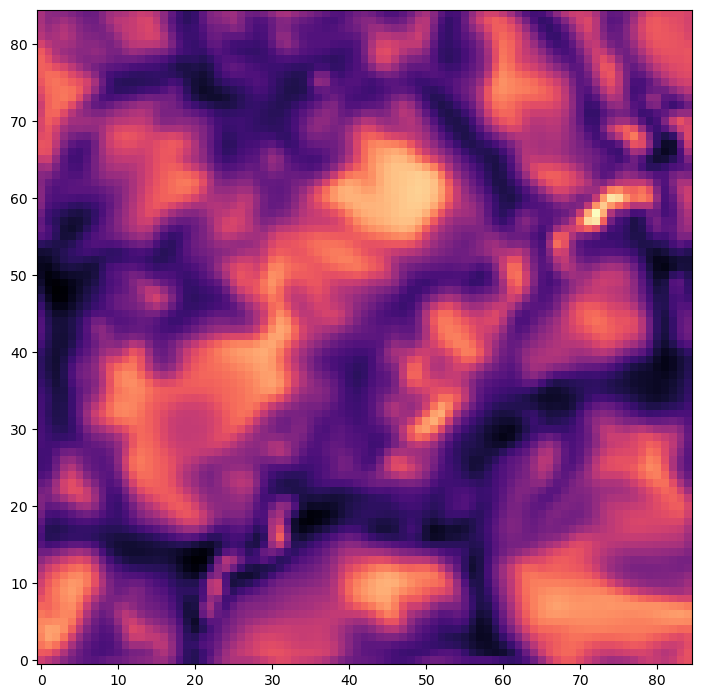

In [3]:
# Importing necessary packages

import MilneEddington as ME
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import sys
import utils as ut

b_c = fits.open('binned_and_convolved_stokes.fits')[0].data
mean_continuum = np.sum(b_c[:,:,0,-10:])
b_c /= mean_continuum

plt.figure(figsize=[16, 8.5])

#plt.subplot(1, 3, 1)
#invert_ptp = fits.open('modelout_pixel-to-pixel.fits')[0].data
#plt.imshow(invert_ptp[:,:,0], origin='lower', cmap='magma')

#plt.subplot(1, 3, 2)
#invert_sc = fits.open('modelout_spatially_coupled.fits')[0].data
#plt.imshow(invert_sc[:,:,0], origin ='lower', cmap='magma')

#plt.subplot(1, 3, 3)
plt.imshow(b_c[:,:,0,0], origin='lower', cmap='magma')
plt.show()